# Multi-sample PCST

Here we demonstrate the use of the multi-sample PCST method, and we also compare against the standard single sample PCST approximation implemented in the `pcst_fast` package

In [1]:
import networkx as nx
import random
import numpy as np
import pcst_fast  # Ensure pcst_fast is installed
import matplotlib.pyplot as plt

def generate_random_graph(num_nodes=100, probability=0.1, num_terminals=10):
    """
    Generates a random unweighted graph using the Erdős-Rényi model and assigns terminal nodes.
    Prizes are not assigned during generation.

    Args:
        num_nodes (int): Number of nodes in the graph.
        probability (float): Probability for edge creation.
        num_terminals (int): Number of nodes to mark as terminals.

    Returns:
        G (networkx.Graph): Graph with a 'terminal' attribute on nodes.
    """
    G = nx.erdos_renyi_graph(num_nodes, probability)

    # Randomly select terminal nodes
    terminals = random.sample(list(G.nodes()), min(num_terminals, G.number_of_nodes()))
    for node in G.nodes():
        G.nodes[node]['terminal'] = (node in terminals)
    
    return G


def assign_random_costs_and_prizes(G, num_prized=10, prize_range=(1, 50)):
    """
    Creates a new copy of the given graph, assigns random edge costs and prizes.
    The original graph remains unchanged. Edge costs are stored in the 'value' attribute.
    Only a specified number of non-terminal nodes receive a random prize; all other nodes are assigned a prize of 0.

    Args:
        G (networkx.Graph): The input graph whose topology is preserved.
        num_prized (int): The number of non-terminal nodes to receive a prize.
        prize_range (tuple): Tuple (min, max) for random prize values.

    Returns:
        G_new (networkx.Graph): A new graph with updated 'value' attributes on edges and 'prize' attributes on nodes.
    """
    # Create a copy of the graph so the original is not modified.
    G_new = G.copy()
    
    # Assign random edge costs
    for u, v in G_new.edges():
        G_new[u][v]['value'] = random.uniform(1, 10)
    
    # Identify non-terminal nodes
    non_terminal_nodes = [node for node in G_new.nodes() if not G_new.nodes[node].get('terminal', False)]
    # Randomly select nodes to assign prizes (do not exceed available nodes)
    prized_nodes = random.sample(non_terminal_nodes, min(num_prized, len(non_terminal_nodes)))
    
    # Assign prizes: nodes selected get a random prize, all others get 0
    for node in G_new.nodes():
        if node in prized_nodes:
            G_new.nodes[node]['prize'] = random.uniform(*prize_range)
        else:
            G_new.nodes[node]['prize'] = 0
    
    return G_new


def solve_pcst_with_pcst_fast(G, root=-1, num_clusters=1, pruning='strong', verbosity=0):
    """
    Solves the PCST problem on a NetworkX graph using the pcst_fast package.

    Args:
        G (networkx.Graph): Graph with 'value' on edges and 'prize' on nodes.
        root (int): Index of the root node (or -1 for unrooted).
        num_clusters (int): Desired number of clusters in the solution.
        pruning (str): Pruning method ('none', 'simple', 'gw', 'strong').
        verbosity (int): Verbosity level.

    Returns:
        selected_nodes (list): Node IDs included in the PCST solution.
        selected_edges (list): Edge tuples included in the solution.
    """
    node_list = list(G.nodes())
    node_index_map = {node: i for i, node in enumerate(node_list)}
    index_node_map = {i: node for node, i in node_index_map.items()}

    edge_list = []
    edge_costs = []
    for u, v, data in G.edges(data=True):
        edge_list.append([node_index_map[u], node_index_map[v]])
        edge_costs.append(data['value'])

    prizes = np.array([G.nodes[node].get('prize', 0) for node in node_list], dtype=np.float64)

    edges_array = np.array(edge_list, dtype=np.int64)
    costs_array = np.array(edge_costs, dtype=np.float64)

    vertices_out, edges_out = pcst_fast.pcst_fast(
        edges_array,
        prizes,
        costs_array,
        root,
        num_clusters,
        pruning,
        verbosity
    )

    selected_nodes = [index_node_map[i] for i in vertices_out]
    selected_edges = [tuple(node_list[idx] for idx in edge_list[i]) for i in edges_out]

    return selected_nodes, selected_edges

def compute_pcst_cost(G, selected_edges):
    """
    Calculates the cost components and total PCST objective value based solely on the selected edges.
    
    The function:
      - Derives the set of selected nodes from the provided edges.
      - Builds a graph using only the selected edges.
      - Checks that the selected edges form a single connected subgraph.
    
    Returns:
        dict with keys 'edge_cost', 'prize_collected', and 'objective'
        
    Raises:
        ValueError: If any provided edge is not in G or if the selected edges do not form a connected subgraph.
    """
    # Derive selected nodes from edges and verify edge validity
    selected_nodes = set()
    for u, v in selected_edges:
        if not G.has_edge(u, v):
            raise ValueError(f"Edge ({u}, {v}) is not present in the graph.")
        selected_nodes.update([u, v])
    
    # For non-empty selections, check connectivity using only the selected edges.
    if selected_edges:
        H = nx.Graph()
        H.add_nodes_from(selected_nodes)
        H.add_edges_from(selected_edges)
        if not nx.is_connected(H):
            raise ValueError("Selected edges do not form a connected subgraph.")
    
    # Calculate the total edge cost.
    edge_cost = sum(G[u][v]['value'] for u, v in selected_edges)
    # Sum the prizes for all nodes in the connected subgraph.
    prize_collected = sum(G.nodes[n].get('prize', 0) for n in selected_nodes)
    objective = edge_cost - prize_collected

    return {
        'edge_cost': edge_cost,
        'prize_collected': prize_collected,
        'objective': objective
    }


def visualize(G, selected_nodes, selected_edges):
    pos = nx.forceatlas2_layout(G, dissuade_hubs=False, seed=42)

    plt.figure(figsize=(8, 8))

    # Base layer: faint background graph
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.5, edge_color='lightgray')
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='lightgray', alpha=0.3)

    # Selected edges (solution)
    nx.draw_networkx_edges(G, pos, edgelist=selected_edges, width=2.5, edge_color='#007acc', alpha=0.9)

    # Selected nodes (solution)
    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_size=150, node_color='#d62728', edgecolors='white', linewidths=0.8)

    # Optional: add labels or prizes
    node_labels = {n: f"{(G.nodes[n].get('prize', 0)):.2f}" for n in selected_nodes}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

    plt.title("pcst_fast approx. solution", fontsize=16, fontweight='bold', pad=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 1. Generate the base graph with a fixed topology (no prizes assigned).
G_original = generate_random_graph(num_nodes=100, probability=0.15, num_terminals=5)

# 2. Create two different samples
G_0 = assign_random_costs_and_prizes(G_original, num_prized=8, prize_range=(1, 50))
G_1 = assign_random_costs_and_prizes(G_original, num_prized=12, prize_range=(1, 50))

# 3. Get an heuristic solution with pcst_fast
selected_nodes_0, selected_edges_0 = solve_pcst_with_pcst_fast(G_0)
selected_nodes_1, selected_edges_1 = solve_pcst_with_pcst_fast(G_1)

compute_pcst_cost(G_0, selected_edges_0), compute_pcst_cost(G_1, selected_edges_1)

{'edge_cost': 20.28406790862805, 'prize_collected': 153.96188356509137, 'objective': -133.6778156564633}
{'edge_cost': 45.15895594982009, 'prize_collected': 388.08151607772595, 'objective': -342.92256012790585}


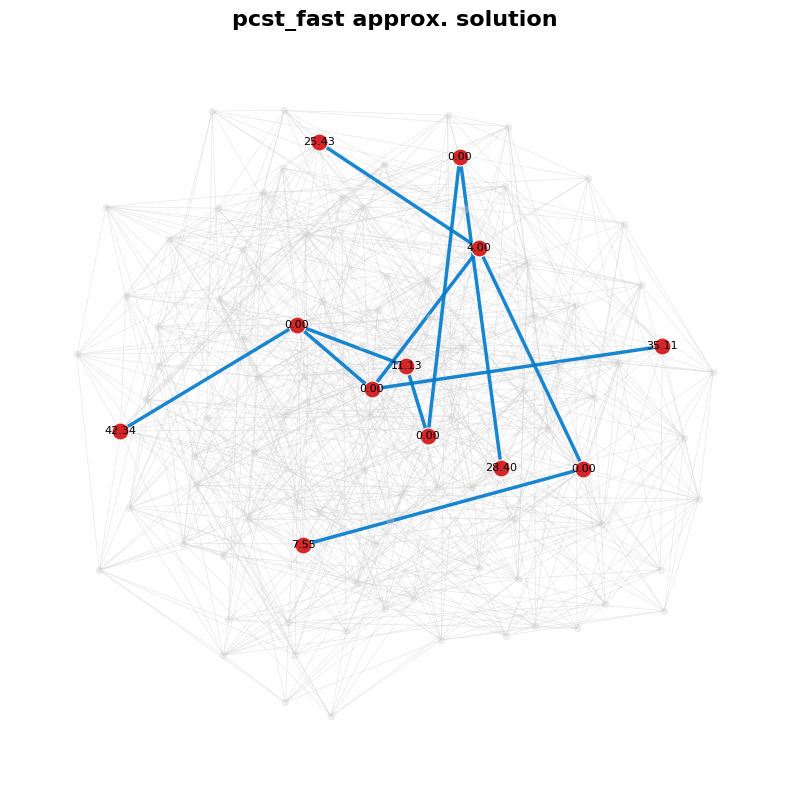

In [2]:
visualize(G_0, selected_nodes_0, selected_edges_0)

## Using CORNETO

In [3]:
from corneto.contrib.networkx import networkx_to_corneto_graph, corneto_graph_to_networkx
Gc0 = networkx_to_corneto_graph(G_0)
Gc0.shape

(100, 730)

In [4]:
from corneto._data import Data

def get_data(G):
    features = []
    
    for i, attr in enumerate(G.get_attr_edges()):
        features.append(dict(id=i, mapping="edge", value=attr.value))

    for v in G.V:
        attr = G.get_attr_vertex(v)
        if attr['terminal'] and not attr.get('prize', None):
            #features.append(dict(id=v, mapping="vertex", role="terminal"))
            pass
        elif attr.get('prize', None):
            features.append(dict(id=v, mapping="vertex", role="prize", value=attr['prize']))
    D = Data.from_dict({"s1": {"features": features}})
    return D

def get_edge_list(graph):
    edges = []
    for s, t in graph.E:
        s = list(s)
        t = list(t)
        if len(s) > 0:
            s = list(s)[0]
        else:
            continue
        if len(t) > 0:
            t = list(t)[0]
        else:
            continue
        edges.append((s, t))
    return edges

D = get_data(Gc0)
D

Data(n_samples=1, n_feats=[738])

In [5]:
from corneto.methods.future.pcst import PrizeCollectingSteinerTree as PCST

m = PCST(lambda_reg=0, strict_acyclic=True)
P = m.build(Gc0, D)
P.solve(solver="gurobi", verbosity=0, TimeLimit=300);

Set parameter Username
Set parameter LicenseID to value 2593994
Academic license - for non-commercial use only - expires 2025-12-02


In [6]:
for o in P.objectives:
    print(o.value)

19.57115127806917
153.96188356509137
19.0


In [7]:
P.objectives[0].value - P.objectives[1].value

-134.3907322870222

In [8]:
G0_sol = m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value > 0.5))
compute_pcst_cost(G_0, get_edge_list(G0_sol))

{'edge_cost': 19.57115127806917,
 'prize_collected': 153.96188356509137,
 'objective': -134.3907322870222}

In [9]:
Gc1 = networkx_to_corneto_graph(G_1)
m = PCST(lambda_reg=0, strict_acyclic=True)
P = m.build(Gc1, get_data(Gc1))
P.solve(solver="gurobi", verbosity=0, TimeLimit=300);

In [10]:
G1_sol = m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value > 0.5))
compute_pcst_cost(G_1, get_edge_list(G1_sol))

{'edge_cost': 41.45862259498969,
 'prize_collected': 388.08151607772595,
 'objective': -346.62289348273623}

In [11]:
# pcst_fast sol
compute_pcst_cost(G_1, selected_edges_1)

{'edge_cost': 45.15895594982009,
 'prize_collected': 388.08151607772595,
 'objective': -342.92256012790585}

## Multi-sample PCST

Now we use multi-sample PCST to simultaneously solve both problems, using the structured sparsity regularization.

In [12]:
# Lets combine both problems into one multi PCST
dataset = get_data(Gc0)
dataset.add_sample("s2", get_data(Gc1).samples["s1"])
dataset

Data(n_samples=2, n_feats=[738 742])

In [13]:
Gc_original = networkx_to_corneto_graph(G_original)
m = PCST(lambda_reg=0, strict_acyclic=True, root_selection_strategy="best")
P = m.build(Gc_original, dataset)
P.solve(solver="gurobi", verbosity=0, TimeLimit=30);

In [14]:
# With no regularization, solutions should be the same
G0_sol = m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value[:,0] > 0.5))
compute_pcst_cost(G_0, get_edge_list(G0_sol))

{'edge_cost': 19.57115127806917,
 'prize_collected': 153.96188356509137,
 'objective': -134.3907322870222}

In [15]:
G1_sol = m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value[:,1] > 0.5))
compute_pcst_cost(G_1, get_edge_list(G1_sol))

{'edge_cost': 41.45862259498969,
 'prize_collected': 388.08151607772595,
 'objective': -346.62289348273623}

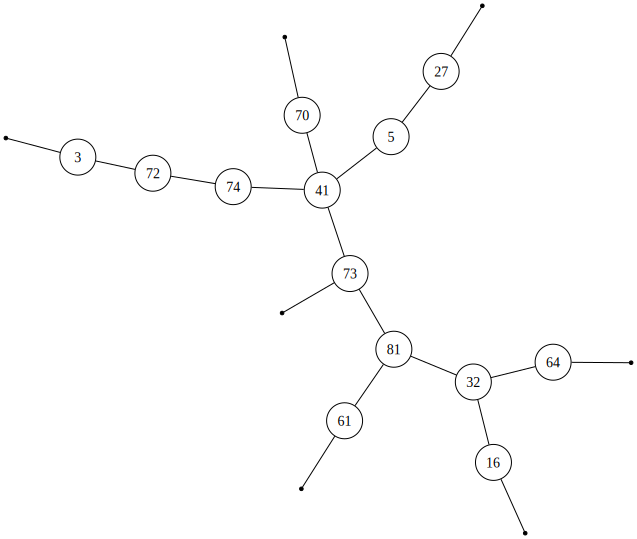

In [16]:
m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value[:,0]>0.5)).plot(layout="neato")

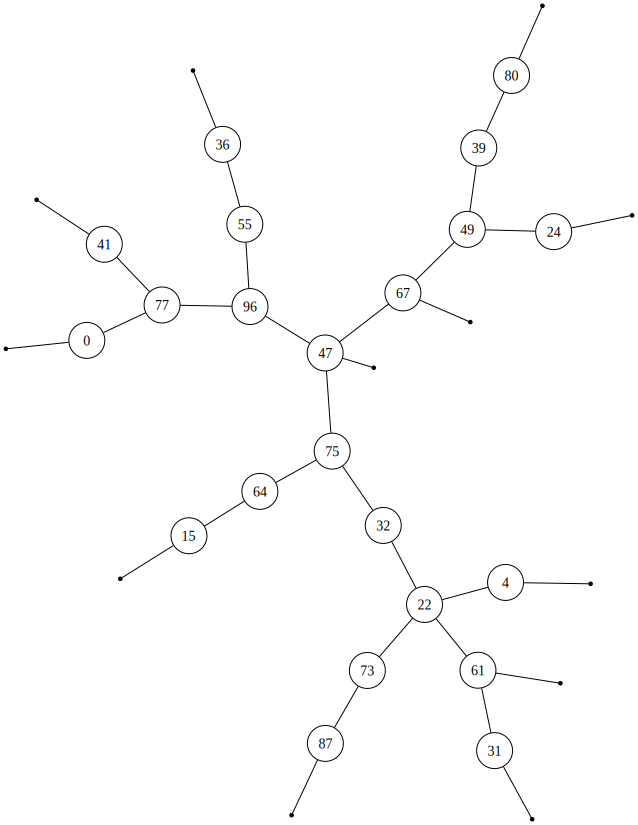

In [17]:
m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value[:,1]>0.5)).plot(layout="neato")

## Testing the effect of $\lambda$

We now evaluate the impact of the structured sparsity-inducing penalty, which encourages entire sets of edges to be excluded across all samples. This penalty helps enforce group-level sparsity, effectively removing certain features from all models simultaneously. To speed up the optimization process, we also leverage Gurobi’s warm-start capability. By setting `warm_start = True`, we can adjust the penalty parameter $\lambda$ and resolve the problem more efficiently, without needing to rebuild the entire optimization model from scratch.

In [18]:
def jaccard_similarity(a, b):
    intersection = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    if union == 0:
        return 1.0  # Define similarity as 1 if both are all zeros
    return intersection / union

def hamming_similarity(a, b):
    return (a == b).sum() / len(a)


In [23]:
results = []
for l in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 10.0, 15.0, 20.0]:
    print(l)
    m.lambda_reg_param.value = l
    P.solve(solver="gurobi", warm_start=True, verbosity=0, TimeLimit=60);
    sol0 = m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value[:,0] > 0.5))
    sol1 = m.processed_graph.edge_subgraph(np.flatnonzero(P.expr.with_flow.value[:,1] > 0.5))
    score1 = compute_pcst_cost(G_0, get_edge_list(sol0))
    score2 = compute_pcst_cost(G_1, get_edge_list(sol1))
    jaccard = jaccard_similarity(P.expr.with_flow.value[:, 0], P.expr.with_flow.value[:, 1])
    hamming = hamming_similarity(P.expr.with_flow.value[:, 0], P.expr.with_flow.value[:, 1])
    results.append((l, score1["objective"], score2["objective"], jaccard, hamming))
    print("Score s1:", score1)
    print("Score s2:", score2)
    print("Jaccard:", jaccard)
    print("Hamming:", hamming)
    print("---")

0.0
Score s1: {'edge_cost': 19.57115127806917, 'prize_collected': 153.96188356509137, 'objective': -134.3907322870222}
Score s2: {'edge_cost': 41.45862259498969, 'prize_collected': 388.08151607772595, 'objective': -346.62289348273623}
Jaccard: 0.0196078431372549
Hamming: 0.9332443257676902
---
0.5
Score s1: {'edge_cost': 19.84536104723518, 'prize_collected': 153.96188356509137, 'objective': -134.1165225178562}
Score s2: {'edge_cost': 42.70194767318196, 'prize_collected': 388.08151607772595, 'objective': -345.379568404544}
Jaccard: 0.02040816326530612
Hamming: 0.9359145527369827
---
1.0
Score s1: {'edge_cost': 20.7032484902457, 'prize_collected': 153.96188356509137, 'objective': -133.25863507484567}
Score s2: {'edge_cost': 42.70194767318196, 'prize_collected': 388.08151607772595, 'objective': -345.379568404544}
Jaccard: 0.022222222222222223
Hamming: 0.9412550066755674
---
1.5
Score s1: {'edge_cost': 16.95422705297661, 'prize_collected': 146.4108923656974, 'objective': -129.4566653127208

<Axes: >

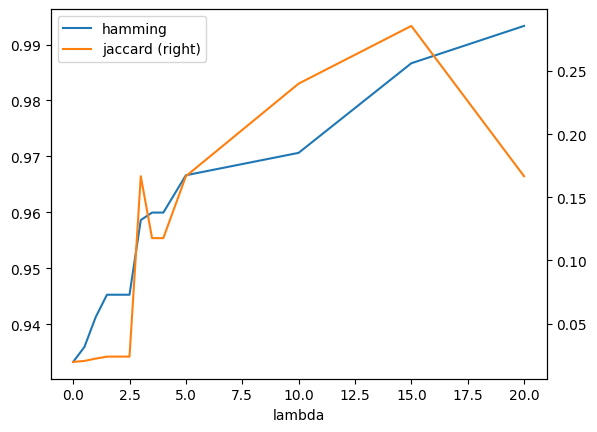

In [34]:
import pandas as pd
df_r = pd.DataFrame(results, columns=["lambda", "obj1", "obj2", "jaccard", "hamming"])
ax = df_r.plot(x="lambda", y="hamming")
df_r.plot(x="lambda", y="jaccard", ax=ax, secondary_y=True)

<Axes: xlabel='obj2'>

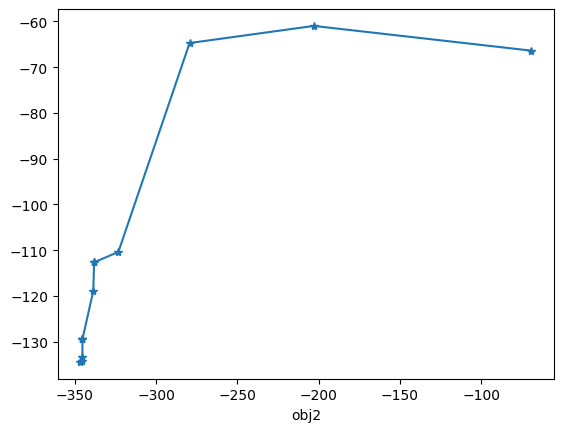

In [45]:
# Obj1 (sample 1) vs Obj 2 (sample 2) for different lambda values
df_r.plot(x="obj2", y="obj1", style="-*", legend=False)